#Cross-pol investigations

In [1]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
import pickle, glob, yaml

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares
from scipy.stats import binned_statistic_2d

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals import beammap as bp
import beamcals.beam_autoprocessing as ba
from beamcals.sites import site


gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')


freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'
ampdir = '/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
beamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/'

In [2]:
def get_flightinfo(fly):
    with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
        documents = yaml.safe_load(fff)
    flights = documents["flight_info"]["flights"]
    
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='N':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f

def get_slice(beam,Z,val, sliceOrientation='h'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[1,0,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[:,0,0]) #figure out the importance of this 
    ok = True
    while(ok):
        if sliceOrientation=='h': #keeping the y value constant and changing the x value 
            sliceIndex = np.where((beam.y_centers_grid[0,:,0] < (val + tol)) & (beam.y_centers_grid[0,:,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
                #still need to do this one 
        if sliceOrientation=='v':#keeping the x value constant and changing the y value 
            sliceIndex = np.where((beam.x_centers_grid[:,0,0] < (val+tol)) & (beam.x_centers_grid[:,0,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=1
        if tol > 30: ok = False
    return sliceIndex[0]


def get_slice_xy(xes,yes,val,ax='x'):
    tol = 2
    if ax=='x':
        col = np.where((xes < val+tol) & (xes > val-tol))[0]
    if ax=='y':
        col = np.where((yes < val+tol) & (yes > val-tol))[0]
    return col

def get_slice(X,Y,Z,val, sliceOrientation='h'):
    # this gradually increases the tolerance until it finds something 
    ok = True
    while(ok):
        if sliceOrientation=='h': #keeping the y value constant and changing the x value 
            tol = abs(Y[0,1] - Y[0,0])/1.5
            sliceIndex = np.where((Y[0,:] < (val + tol)) & (Y[0,:] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
                #still need to do this one 
        if sliceOrientation=='v': #keeping the x value constant and changing the y value 
            tol = abs(X[1,0] - X[0,0])/1.5
            sliceIndex = np.where((X[:,0] < (val+tol)) & (X[:,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=1
        if tol > 30: ok = False
    return sliceIndex[0]


def get_stat(new_d,whstat='stddev'): # default is stddev
    diff_flat = np.ndarray.flatten(new_d)
    if whstat=='stddev':
        stat = np.nanstd(diff_flat)
    elif whstat=='median':
        # compute median
        stat = np.abs(np.nanmedian(diff_flat))
    elif whstat=='sum':
        stat = np.nanmean(np.abs(diff_flat))
    return stat

In [3]:
with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
masks = documents["flight_info"]["masks"]
good_freqs = documents["freq_info"]["good_freqs"]

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))
print(gfitarr,amparr)


# SLICE DEFAULTS # 
sliw = 10 # This defines slices for (some) plots
sz = 80 # use this to set the size of the Xargs and Yargs for beammapping, usually 80 or 50

# PLOTTING DEFAULT # 
cmap = matplotlib.cm.get_cmap('gnuplot2')
norm = matplotlib.colors.Normalize(vmin=-25, vmax=25)
sfig = False

Npolflights = ['618','619','625','646','647','533','536']
Epolflights = ['620','648','649','535']

find = 900

cmm = cm.magma
fsz=16

['FLY533_20210826T182904Z_2dGauss_and_Airy_Params.npz'
 'FLY534_20210826T185621Z_2dGauss_and_Airy_Params.npz'
 'FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz'
 'FLY536_20210826T195003Z_2dGauss_and_Airy_Params.npz'
 'FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz'
 'FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz'
 'FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz'
 'FLY623_20211021T203206Z_2dGauss_and_Airy_Params.npz'
 'FLY625_20211021T214028Z_2dGauss_and_Airy_Params.npz'
 'FLY646_20211022T183659Z_2dGauss_and_Airy_Params.npz'
 'FLY647_20211022T185749Z_2dGauss_and_Airy_Params.npz'
 'FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz'
 'FLY649_20211022T194308Z_2dGauss_and_Airy_Params.npz'] ['FLY533_Corrected_amplitudes.pkl' 'FLY534_Corrected_amplitudes.pkl'
 'FLY535_Corrected_amplitudes.pkl' 'FLY536_Corrected_amplitudes.pkl'
 'FLY618_Corrected_amplitudes.pkl' 'FLY619_Corrected_amplitudes.pkl'
 'FLY620_Corrected_amplitudes.pkl' 'FLY623_Corrected_amplitudes.pkl'
 'FLY625

In [4]:
## Look at amplitudes from flight 618, 619 620, 623, 625:

pflights = ['618','619','623','625']
normarr = np.zeros([1024,16,len(pflights)])

for i, fly in enumerate(pflights):
    if fly == '618':
        normarr[:,i] = 1.0
    elif fly == '620':
        normarr[:,i] = 1.0
    elif fly in Npolflights[1::]:
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        Gamp = np.swapaxes(fits['G_popt'][:,:,0],0,1)
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        with open(pklfile, 'rb') as inp:
            amps = pickle.load(inp)
        normarr[:,:,i] = Gamp*amps[0,:,:]
    elif fly in Epolflights[1::]:
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        Gamp = np.swapaxes(fits['G_popt'][:,:,0],0,1)
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        with open(pklfile, 'rb') as inp:
            amps = pickle.load(inp)
        normarr[:,:,i] = Gamp*amps[0,:,:]
    

In [ ]:
for i, fly in enumerate(pflights):
    plt.plot(freqs,normarr[:,1,i],label=fly)
plt.xlim(400,600)
plt.legend()
plt.show()

for p in N_pols:
    plt.plot(freqs[good_freqs],
             2*(normarr[good_freqs,p,3]-normarr[good_freqs,p,1])/(normarr[good_freqs,p,3]+normarr[good_freqs,p,1]),
             label=str(p),marker='.',linestyle='None')
plt.xlim(400,600)
plt.ylim(-0.3,0.3)
plt.legend()
plt.show()

for p in N_pols:
    tt = np.mean(2*(normarr[good_freqs,p,3]-normarr[good_freqs,p,1])/(normarr[good_freqs,p,3]+normarr[good_freqs,p,1]),axis=0)
    print('Input: ',p, 'Average difference between normalizations across all good frequencies: ', tt)
    
find = 900
tt = np.nanmean(2*(normarr[find,N_pols,3]-normarr[find,N_pols,1])/(normarr[find,N_pols,3]+normarr[find,N_pols,1]),axis=0)
print('Average difference across inputs between normalizations at input : ', find, tt)

for p in N_pols:
    print(p, normarr[find,p,3], normarr[find,p,1])

In [ ]:
## Plan: ##
# 1. Read in flight 618 (N pol flight)
# 2. divide N pols by corresponding Gaussian fits
# 3. read in Gauss fits for flight 620 (Epol flight)
# 4. divide E pols by flight 620 Gauss fits
# 5. Read in 620 flight
# 6. divide E pols by 620 fits
# 7. overplot E-pol copol (flight 620) and Epol cross pol (flight 618)
# 8. divide N pols in 620 with Gaussian fits for 618
# 9. overplot N pol copol (flight 618) and Npol cross pol (flight 620)

In [ ]:
##############################################
##### This is with raw data and concats ######
##############################################

# Read in Flight 618
fly = '618'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)

# Choose which dish here

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
print(concytest)

with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    concattest618=pickle.load(pfile)
t_cut_618=concattest618.inds_on    

fly = '620'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)

# Choose which dish here

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
print(concytest)

with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    concattest620=pickle.load(pfile)
t_cut_620=concattest620.inds_on    

In [ ]:
## Read in Gaussian fit params:

fly = '618'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits618 = np.load(ffile)
gp_618 = abs(fits618['G_popt'][:,:,0]) # amplitude

print(gp_618)

fly = '620'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits620 = np.load(ffile)
gp_620 = abs(fits620['G_popt'][:,:,0]) # amplitude

print(gp_620)

In [ ]:
## Let's start by checking regular co-pol normalization - N pol: 

chind=1
print(concattest618.G_popt[chind,find,:])

x = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
y = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
z = concattest618.V_bgsub[t_cut_618,find,chind] / gp_618[chind,find]


# plot scatter plot and beam map
plt.figure(1,figsize=(10,10))
plt.scatter(x,y,c=z,cmap=cm.gnuplot2,norm=LogNorm())
plt.colorbar()
plt.show()

# grab a slice and plot it

ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
plt.semilogy(y[ixd],z[ixd],'b.',label='copol')
plt.show()


In [ ]:
## Now let's plot slices together - N pol
colors=pu.cm_to_discrete(cmm, 3)

# Flight 618, N pol (1 is a good input)
chind=1

x = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
y = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
z = concattest618.V_bgsub[t_cut_618,find,chind] / gp_618[chind,find]

# grab a slice and plot it

ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice

plt.figure(1,figsize=(10,10))
plt.semilogy(y[ixd],z[ixd],color=colors[0],marker='.',linestyle='None',label='copol')

## Let's look at that same channel, in cross-pol flight, divide by same value:

x = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
y = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
z = concattest620.V_bgsub[t_cut_620,find,chind] / gp_618[chind,find]


# grab a slice and plot it

ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
plt.semilogy(y[ixd],z[ixd],color=colors[1],marker='.',linestyle='None',label='cross-pol')
plt.legend()
plt.show()

In [ ]:
# Repeat for E pol

chind=0
x = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
y = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
z = concattest620.V_bgsub[t_cut_620,find,chind] / np.abs(gp_620[chind,find])
print(gp_620[chind,find])

# plot scatter plot and beam map
plt.figure(1,figsize=(10,10))
plt.scatter(x,y,c=z,cmap=cm.gnuplot2,norm=LogNorm())
plt.colorbar()
plt.show()

# grab a slice and plot it
plt.figure(1,figsize=(10,10))
ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
plt.semilogy(y[ixd],z[ixd],'r.',label='cross-pol')



In [ ]:
# Now reverse - plot slices together, E pol

# Flight 620, E pol (0 is a good input)
chind=0
x = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
y = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
z = concattest620.V_bgsub[t_cut_620,find,chind] / np.abs(gp_620[chind,find])
print(gp_620[chind,find])


# grab a slice and plot it
plt.figure(1,figsize=(10,10))
ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
plt.semilogy(y[ixd],z[ixd],'r.',label='cross-pol')

# Flight 618, N pol (1 is a good input)
x = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
y = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
z = concattest618.V_bgsub[t_cut_618,find,chind] / gp_620[chind,find]

# grab a slice and plot it

ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
plt.semilogy(y[ixd],z[ixd],'b.',label='copol')
plt.show()



In [ ]:
len(N_pols)

In [ ]:
## Now let's plot slices together - N pol
colors=pu.cm_to_discrete(cmm, 3)
find = 900

chind=1
print(concattest618.G_popt[chind,find,:])

fig = plt.figure(figsize=(20,6))
plt.subplot(2,5,1)

for i,chind in enumerate(N_pols):
    # Flight 618, N pol (1 is a good input)
    xco = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
    yco = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
    zco = concattest618.V_bgsub[t_cut_618,find,chind] / gp_618[chind,find]

    ## Let's look at that same channel, in cross-pol flight, divide by same value:
    xcrs = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
    ycrs = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
    zcrs = concattest620.V_bgsub[t_cut_620,find,chind] / gp_618[chind,find]

    # plot scatter plot and beam map
    plt.subplot(2,5,i+1)
    plt.scatter(xco,yco,c=zco,cmap=cm.magma,vmax=1.0,vmin=1E-4,norm=LogNorm())
    plt.title('Input '+str(chind))
    plt.ylim(-50,50)
    plt.xlim(-50,50)
    plt.colorbar()
    #plt.show()
    
    # plot scatter plot and beam map
    
    plt.subplot(2,5,6+i)
    plt.scatter(xcrs,ycrs,c=zcrs,cmap=cm.magma,vmax=1.0,vmin=1E-4,norm=LogNorm())
    plt.colorbar()
    plt.ylim(-50,50)
    plt.xlim(-50,50)
plt.suptitle('Frequency: '+str(freqs[find])+' MHz')
plt.show()






<ipython-input-15-8f0b682fe78b>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,5,i+1)


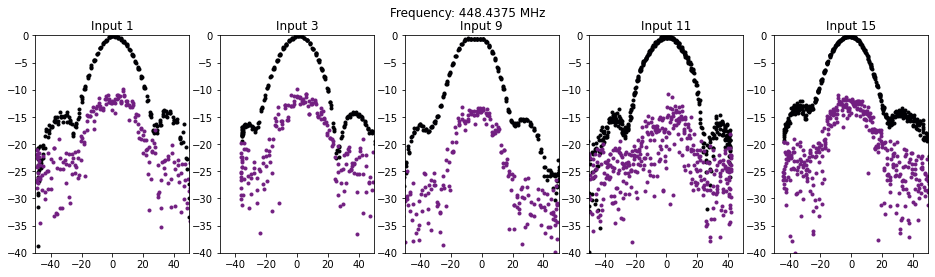

In [15]:
fig = plt.figure(figsize=(16,4))
plt.subplot(1,5,1)

for i,chind in enumerate(N_pols):
    # Flight 618, N pol (1 is a good input)
    xco = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
    yco = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
    zco = concattest618.V_bgsub[t_cut_618,find,chind] / gp_618[chind,find]

    ## Let's look at that same channel, in cross-pol flight, divide by same value:
    xcrs = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
    ycrs = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
    zcrs = concattest620.V_bgsub[t_cut_620,find,chind] / gp_618[chind,find]
    
    ixd = get_slice_xy(xco,yco,0.0,ax='x') # grabbed x slice
    plt.subplot(1,5,i+1)
    plt.title('Input '+str(chind))
    plt.plot(yco[ixd],10*np.log10(abs(zco[ixd])),color=colors[0],marker='.',linestyle='None',label='copol')
    plt.ylim(-40,0)
    plt.xlim(-50,50)
    
    ixd = get_slice_xy(xcrs,ycrs,0.0,ax='x') # grabbed x slice
    plt.plot(ycrs[ixd],10*np.log10(abs(zcrs[ixd])),color=colors[1],marker='.',linestyle='None',label='cross-pol')
    plt.ylim(-40,0)
    plt.xlim(-50,50)

plt.suptitle('Frequency: '+str(freqs[find])+' MHz')
plt.show()


[ 4.28831085e-08 -2.85748077e+00  9.75495920e+00  1.34109007e+00
  9.17015906e+00  4.52712120e-10  0.00000000e+00]


<ipython-input-16-46ee44415fe3>:22: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  axs[0,i].scatter(xco,yco,c=zco,cmap=cm.magma,vmax=1.0,vmin=1E-4,s=8,norm=LogNorm())
<ipython-input-16-46ee44415fe3>:33: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = axs[1,i].scatter(xcrs,ycrs,c=zcrs,cmap=cm.magma,vmax=1.0,vmin=1E-4,s=8,norm=LogNorm())
<ipython-input-16-46ee44415fe3>:22: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  axs[0,i].scatter(xco,yco,c=zco,cmap=cm.magma,vmax=1.0

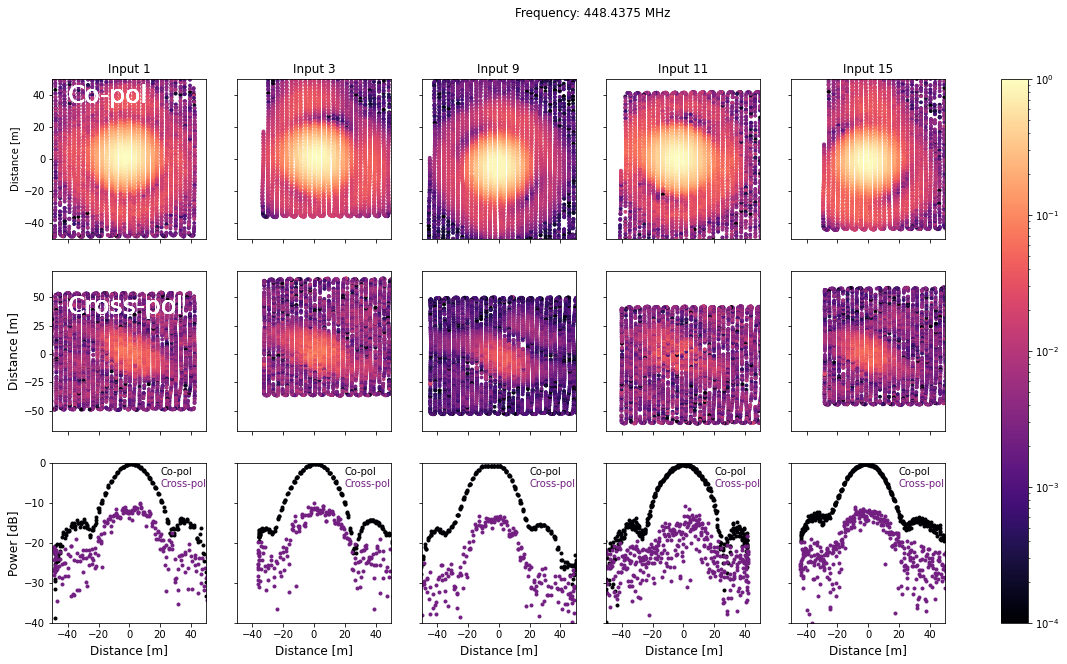

In [16]:
## Now let's plot slices together - N pol
colors=pu.cm_to_discrete(cmm, 3)
find = 900

chind=1
print(concattest618.G_popt[chind,find,:])

fig, axs = plt.subplots(3,5, sharex=True,sharey='row',figsize=(20,10))

for i,chind in enumerate(N_pols):
    # Flight 618, N pol (1 is a good input)
    xco = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
    yco = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
    zco = concattest618.V_bgsub[t_cut_618,find,chind] / gp_618[chind,find]

    ## Let's look at that same channel, in cross-pol flight, divide by same value:
    xcrs = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
    ycrs = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
    zcrs = concattest620.V_bgsub[t_cut_620,find,chind] / gp_618[chind,find]

    # plot scatter plot and beam map
    axs[0,i].scatter(xco,yco,c=zco,cmap=cm.magma,vmax=1.0,vmin=1E-4,s=8,norm=LogNorm())
    axs[0,0].text(-40,35,'Co-pol',color='white',fontsize=25)
    axs[0,0].set_ylabel('Distance [m]',fontsize=10)
    axs[0,i].set_title('Input '+str(chind))
    
    axs[0,i].set_ylim(-50,50)
    axs[0,i].set_xlim(-50,50)
    #axs[0,i].colorbar()
    
    # plot scatter plot and beam map
    
    im = axs[1,i].scatter(xcrs,ycrs,c=zcrs,cmap=cm.magma,vmax=1.0,vmin=1E-4,s=8,norm=LogNorm())
    axs[1,0].text(-40,35,'Cross-pol',color='white',fontsize=25)
    axs[1,0].set_ylabel('Distance [m]',fontsize=12)
    #axs[1,i].colorbar()
    #axs[1,i].ylim(-50,50)
    #axs[1,i].xlim(-50,50)
    
    
    # plot a cross-section
    ixd = get_slice_xy(xco,yco,0.0,ax='x') # grabbed x slice
    axs[2,i].plot(yco[ixd],10*np.log10(abs(zco[ixd])),color=colors[0],marker='.',linestyle='None',label='copol')
    
    ixd = get_slice_xy(xcrs,ycrs,0.0,ax='x') # grabbed x slice
    axs[2,i].plot(ycrs[ixd],10*np.log10(abs(zcrs[ixd])),color=colors[1],marker='.',linestyle='None',label='cross-pol')
    axs[2,i].text(20,-3,'Co-pol',color=colors[0])
    axs[2,i].text(20,-6,'Cross-pol',color=colors[1])
    axs[2,0].set_ylabel('Power [dB]',fontsize=12)
    axs[2,i].set_ylim(-40,0.1)
    axs[2,i].set_xlim(-50,50)
    axs[2,i].set_xlabel('Distance [m]',fontsize=12)
fig.colorbar(im, ax=axs.ravel().tolist())   
fig.suptitle('Frequency: '+str(freqs[find])+' MHz')
plt.show()

[ 4.28831085e-08 -2.85748077e+00  9.75495920e+00  1.34109007e+00
  9.17015906e+00  4.52712120e-10  0.00000000e+00]


<ipython-input-17-779bb0744478>:22: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  axs[0,i].scatter(xco,yco,c=zco,cmap=cm.magma,vmax=1.0,vmin=1E-4,s=8,norm=LogNorm())
<ipython-input-17-779bb0744478>:33: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = axs[1,i].scatter(xcrs,ycrs,c=zcrs,cmap=cm.magma,vmax=1.0,vmin=1E-4,s=8,norm=LogNorm())
<ipython-input-17-779bb0744478>:22: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  axs[0,i].scatter(xco,yco,c=zco,cmap=cm.magma,vmax=1.0

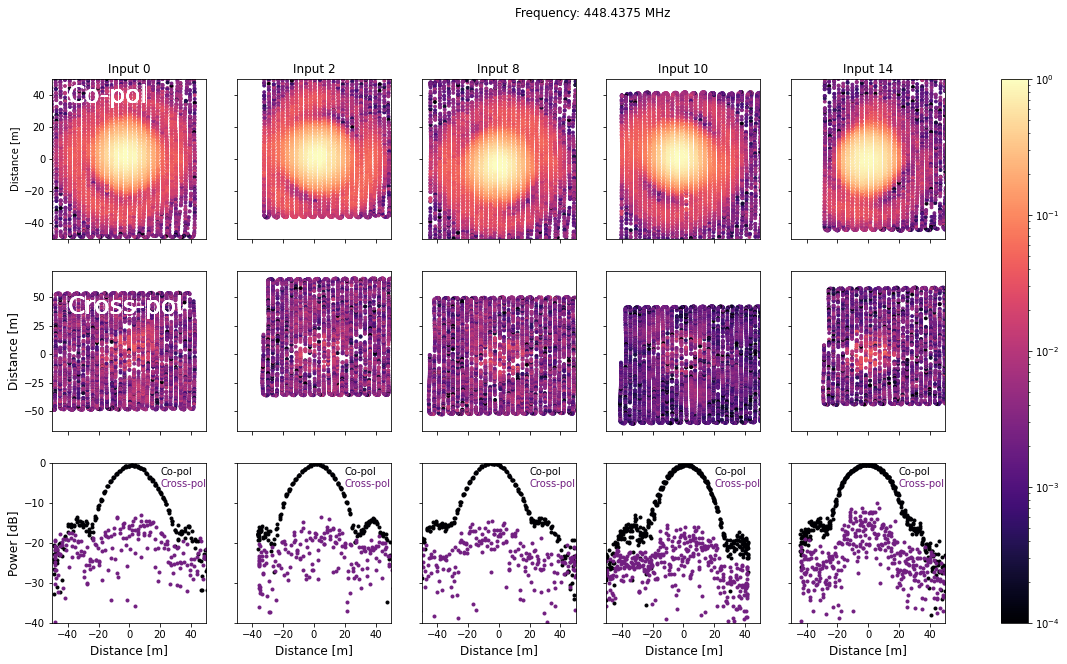

In [17]:
## Now let's plot slices together - E pol
colors=pu.cm_to_discrete(cmm, 3)
find = 900

chind=1
print(concattest618.G_popt[chind,find,:])

fig, axs = plt.subplots(3,5, sharex=True,sharey='row',figsize=(20,10))

for i,chind in enumerate(E_pols):
    # Flight 620, E pol (0 is a good input)
    xco = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
    yco = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
    zco = concattest620.V_bgsub[t_cut_620,find,chind] / gp_620[chind,find]

    ## Let's look at that same channel, in cross-pol flight, divide by same value:
    xcrs = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
    ycrs = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
    zcrs = concattest618.V_bgsub[t_cut_618,find,chind] / gp_620[chind,find]

    # plot scatter plot and beam map
    axs[0,i].scatter(xco,yco,c=zco,cmap=cm.magma,vmax=1.0,vmin=1E-4,s=8,norm=LogNorm())
    axs[0,0].text(-40,35,'Co-pol',color='white',fontsize=25)
    axs[0,0].set_ylabel('Distance [m]',fontsize=10)
    axs[0,i].set_title('Input '+str(chind))
    
    axs[0,i].set_ylim(-50,50)
    axs[0,i].set_xlim(-50,50)
    #axs[0,i].colorbar()
    
    # plot scatter plot and beam map
    
    im = axs[1,i].scatter(xcrs,ycrs,c=zcrs,cmap=cm.magma,vmax=1.0,vmin=1E-4,s=8,norm=LogNorm())
    axs[1,0].text(-40,35,'Cross-pol',color='white',fontsize=25)
    axs[1,0].set_ylabel('Distance [m]',fontsize=12)
    #axs[1,i].colorbar()
    #axs[1,i].ylim(-50,50)
    #axs[1,i].xlim(-50,50)
    
    
    # plot a cross-section
    ixd = get_slice_xy(xco,yco,0.0,ax='x') # grabbed x slice
    axs[2,i].plot(yco[ixd],10*np.log10(abs(zco[ixd])),color=colors[0],marker='.',linestyle='None',label='copol')
    
    ixd = get_slice_xy(xcrs,ycrs,0.0,ax='x') # grabbed x slice
    axs[2,i].plot(ycrs[ixd],10*np.log10(abs(zcrs[ixd])),color=colors[1],marker='.',linestyle='None',label='cross-pol')
    axs[2,i].text(20,-3,'Co-pol',color=colors[0])
    axs[2,i].text(20,-6,'Cross-pol',color=colors[1])
    axs[2,0].set_ylabel('Power [dB]',fontsize=12)
    axs[2,i].set_ylim(-40,0.1)
    axs[2,i].set_xlim(-50,50)
    axs[2,i].set_xlabel('Distance [m]',fontsize=12)
fig.colorbar(im, ax=axs.ravel().tolist())   
fig.suptitle('Frequency: '+str(freqs[find])+' MHz')
plt.show()

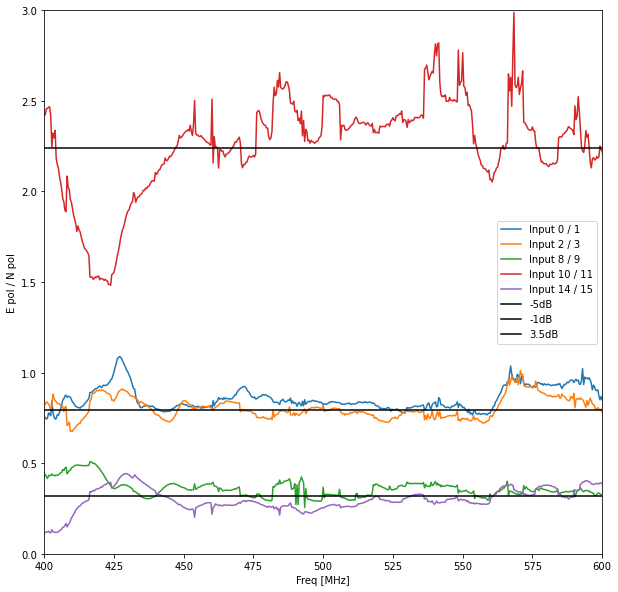

In [18]:
# check the ratio of gains between X and Y pols, to compare to 360 rotations
plt.figure(1,figsize=(10,10))
for chind in pols:
    plt.plot(freqs,gp_620[chind,:]/gp_618[chind+1,:],label='Input '+str(chind)+' / '+str(chind+1))
plt.xlim(400,600)
plt.ylim(0,3)
plt.axhline(10**(-5.0/10.),label='-5dB',color='black')
plt.axhline(10**(-1/10.),label='-1dB',color='black')
plt.axhline(10**(3.5/10.),label='3.5dB',color='black')
plt.ylabel('E pol / N pol')
plt.xlabel('Freq [MHz]')
plt.legend()
plt.show()

In [42]:
## Class for position-space sorting/averaging of beammap flight data, from time domain data:
#defines coordinate vector from xmax to xmin spaced roughly by xres:

def cedges(args):
    cmin,cmax,cres=args
    return np.linspace(cmin,cmax,int((cmax-cmin)/cres)+1)


def get_coord_locs(coordsys,d0args,d1args,n_channels):
    ## Determine Coordinate System: coordsys='cartesian' or 'polar':
    if coordsys=='cartesian':
        Xargs=d0args
        Yargs=d1args
        #create x,y cartesian vectors (edges and centers) and grids for the beammap:
        xedges,yedges=(cedges(Xargs),cedges(Yargs))
        xedgesgrid,yedgesgrid=np.meshgrid(xedges,yedges,indexing='ij')
        xcenters,ycenters=(cedges(Xargs)[:-1]+Xargs[2]/2.0,cedges(Yargs)[:-1]+Yargs[2]/2.0)
        xcentersgrid,ycentersgrid=np.meshgrid(xcenters,ycenters,indexing='ij')        
        #need to extend this to dimensionality of channels in concatclass.V
        d0_edges=np.zeros(xedges.shape+(n_channels,))
        d1_edges=np.zeros(yedges.shape+(n_channels,))
        d0_edges_grid=np.zeros((xedgesgrid.shape+(n_channels,)))
        d1_edges_grid=np.zeros((yedgesgrid.shape+(n_channels,)))
        d0_centers=np.zeros(xcenters.shape+(n_channels,))
        d1_centers=np.zeros(ycenters.shape+(n_channels,))
        d0_centers_grid=np.zeros((xcentersgrid.shape+(n_channels,)))
        d1_centers_grid=np.zeros((ycentersgrid.shape+(n_channels,)))
        for i in range(n_channels):
            d0_edges[:,i]=xedges
            d0_centers[:,i]=xcenters
            d1_edges[:,i]=yedges
            d1_centers[:,i]=ycenters
            d0_centers_grid[:,:,i]=xcentersgrid
            d1_centers_grid[:,:,i]=ycentersgrid
            d0_edges_grid[:,:,i]=xedgesgrid
            d1_edges_grid[:,:,i]=yedgesgrid
    if coordsys=='polar':
        theta_args=d0args
        phi_args=d1args
        #create x,y cartesian vectors (edges and centers) and grids for the beammap:
        thetaedges,phiedges=(cedges(theta_args),cedges(phi_args))
        thetaedgesgrid,phiedgesgrid=np.meshgrid(thetaedges,phiedges,indexing='ij')
        thetacenters,phicenters=(cedges(theta_args)[:-1]+theta_args[2]/2.0,cedges(phi_args)[:-1]+phi_args[2]/2.0)
        thetacentersgrid,phicentersgrid=np.meshgrid(thetacenters,phicenters,indexing='ij')        
        #need to extend this to dimensionality of channels in concatclass.V
        d0_edges=np.zeros(thetaedges.shape+(n_channels,))
        d1_edges=np.zeros(phiedges.shape+(n_channels,))
        d0_edges_grid=np.zeros((thetaedgesgrid.shape+(n_channels,)))
        d1_edges_grid=np.zeros((phiedgesgrid.shape+(n_channels,)))
        d0_centers=np.zeros(thetacenters.shape+(n_channels,))
        d1_centers=np.zeros(phicenters.shape+(n_channels,))
        d0_centers_grid=np.zeros((thetacentersgrid.shape+(n_channels,)))
        d1_centers_grid=np.zeros((phicentersgrid.shape+(n_channels,)))
        for i in range(n_channels):
            d0_edges[:,i]=thetaedges
            d0_centers[:,i]=thetacenters
            d1_edges[:,i]=phiedges
            d1_centers[:,i]=phicenters
            d0_centers_grid[:,:,i]=thetacentersgrid
            d1_centers_grid[:,:,i]=phicentersgrid
            d0_edges_grid[:,:,i]=thetaedgesgrid
            d1_edges_grid[:,:,i]=phiedgesgrid    
    return d0_edges, d0_centers, d1_edges, d1_centers, d0_centers_grid, d1_centers_grid, d0_edges_grid, d1_edges_grid                 
    
def get_maskvals(coordsys):
    if coordsys=='cartesian':
        maskin = 18
        maskout = 40
    if coordsys=='polar':
        maskin = 6*np.pi/180.
        maskout = 12*np.pi/180
    return maskin, maskout

        
class Beammap_nonorm:
    
    def __init__(self,concatlist=[],#coordsys='cartesian',d0args=[-100,100,5],d1args=[-100,100,5],\
                 coordsys='polar',d0args=[0,360*(np.pi/180.0),6*(np.pi/180.0)],d1args=[0,25*(np.pi/180.0),0.5*(np.pi/180.0)],\
                 Fargs=[0,1024,1],f_index=900,\
                 operation='coadd',inputstyle='pickle',vplot=False,\
                 pickle_directory='/hirax/GBO_Analysis_Outputs/flight_pickles/',\
                 gfit_directory='/hirax/GBO_Analysis_Outputs/main_beam_fits/',\
                 flightmasterpath='/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml',\
                 ampcorr_directory='/hirax/GBO_Analysis_Outputs/amplitude_corrections/',\
                 include_cross_data=False,mask=False):
        ## enable format of input to be load from 'pickle' filestring or bin/map using concat 'class':        
        self.gfit_directory = gfit_directory
        self.ampcorr_directory = ampcorr_directory  
        self.pickle_directory = pickle_directory
        nchanslist=np.zeros(len(concatlist))


        for h,cstring in enumerate(concatlist):
            print(cstring)
            ## using the with loop structure, the pickle file is closed after ccc is loaded:
            with open(cstring, "rb") as f:
                CONCATCLASS=pickle.load(f)
            nchanslist[h]=CONCATCLASS.n_channels
            self.FLYNUM=cstring.split('FLY')[1].split('_')[0]
        ## determine which channel is co-pol, for frequency dependent centroid corrections:
        with open(flightmasterpath, 'r') as flightmaster:
            doccs = yaml.safe_load(flightmaster)
            for j,fstr in enumerate(doccs['flight_info']['flights']):
                if self.FLYNUM in fstr:
                    self.copoldir=doccs['flight_info']['pols'][j]
        #get variables that should be kept along from the first concat class:         
        self.name=CONCATCLASS.name
        self.Data_Directory=CONCATCLASS.Data_Directory
        self.Gain_Directory=CONCATCLASS.Gain_Directory
        self.filenames=CONCATCLASS.filenames
        self.gainfile=CONCATCLASS.gainfile
        self.Drone_Directory=CONCATCLASS.Drone_Directory
        self.FLYTAG=CONCATCLASS.FLYTAG
        self.n_dishes=CONCATCLASS.n_dishes
        self.n_channels=int(np.nanmin(nchanslist))
        self.n_concats=len(concatlist)
        self.chmap=CONCATCLASS.chmap
        self.automap=CONCATCLASS.automap
        self.crossmap=CONCATCLASS.crossmap
        self.origin=CONCATCLASS.origin
        #self.prime_origin=CONCATCLASS.prime_origin ## omit, it breaks the pickle
        self.dish_keystrings=CONCATCLASS.dish_keystrings
        self.dish_coords=CONCATCLASS.dish_coords
        self.dish_pointings=CONCATCLASS.dish_pointings
        self.dish_polarizations=CONCATCLASS.dish_polarizations
        self.fmin,self.fmax,self.fstep=Fargs
        self.faxis=np.arange(self.fmin,self.fmax,self.fstep)
        self.n_freqs=len(self.faxis)
        self.freq=CONCATCLASS.freq[self.faxis]
        find=np.where(self.faxis==f_index)[0][0]
        self.operation=operation
        self.coordsys=coordsys
        
        (self.d0_edges, self.d0_centers, self.d1_edges, self.d1_centers, 
             self.d0_centers_grid, self.d1_centers_grid, self.d0_edges_grid, 
             self.d1_edges_grid) = get_coord_locs(coordsys,d0args,d1args,self.n_channels)

        ## now need frequency dependent offset terms in shape (freq, channel, concat) to mimic V
        self.x_offsets=np.NAN*np.ones((len(self.freq),self.n_channels,self.n_concats))
        self.y_offsets=np.NAN*np.ones((len(self.freq),self.n_channels,self.n_concats))        
        ## create arrays for V mean, V std, and histo: shape is (gridx, gridy, freq, chans, concatlist)
        self.V_LC_mean=np.NAN*np.ones((len(self.d0_centers[:,0]),len(self.d1_centers[:,0]),len(self.freq),self.n_channels,self.n_concats))
        self.V_LC_std=np.NAN*np.ones((len(self.d0_centers[:,0]),len(self.d1_centers[:,0]),len(self.freq),self.n_channels,self.n_concats))
        self.histogram_LC=np.NAN*np.ones((len(self.d0_centers[:,0]),len(self.d1_centers[:,0]),len(self.freq),self.n_channels,self.n_concats))
        ## create arrays for V mean, V std, and histo: shape is (gridx, gridy, freq, chans, concatlist)
        self.V_LC_sum=np.NAN*np.ones((len(self.d0_centers[:,0]),len(self.d1_centers[:,0]),
                                      self.n_freqs,self.n_channels,self.n_concats))
        self.V_LC_count=np.NAN*np.ones((len(self.d0_centers[:,0]),len(self.d1_centers[:,0]),
                                        self.n_freqs,self.n_channels,self.n_concats))
            
        print("start of big ass loop is: {}".format(datetime.datetime.now()))
        
        for h,cstring in enumerate(concatlist):
            self.FLYNUM=cstring.split('FLY')[1].split('_')[0]
            
            Vvals, fccoords = self.get_VVals_tempcoords(cstring,h,doccs)                       

            ## loop through channels (i,chan) to find indices of nonzero cells in histogram
            for i,chan in enumerate(range(self.n_channels)):
                for j,fr in enumerate(self.faxis):
                    print('autos: Concat:{}/{}, Channel:{}/{}, Frequency:{}/{},           '.format(h+1,self.n_concats,i+1,self.n_channels,j+1,len(self.freq)),end='\r')
                    if coordsys=='cartesian':
                        xf,yf=fccoords[i,:,0,j],fccoords[i,:,1,j]
                    elif coordsys=='polar':
                        polcoords=np.array([gu.xyz_to_rpt(fccoords[i,k,:,j]) for k in range(len(fccoords[i,:,:,j]))])
                        xf,yf=polcoords[:,1],polcoords[:,2]                      
                    valsf=Vvals[:,j,i]    
                    
                    #histo2d,xbins,ybins=np.histogram2d(x,y,bins=[self.x_edges[:,i],self.y_edges[:,i]])
                    self.histogram_LC[:,:,j,i,h]=binned_statistic_2d(x=xf,y=yf,values=valsf,statistic='count',bins=[self.d0_edges[:,i],self.d1_edges[:,i]]).statistic
                    self.V_LC_sum[:,:,j,i,h]=binned_statistic_2d(x=xf,y=yf,values=valsf,statistic='sum',bins=[self.d0_edges[:,i],self.d1_edges[:,i]]).statistic
                    self.V_LC_count[:,:,j,i,h]=binned_statistic_2d(x=xf,y=yf,values=valsf,statistic='count',bins=[self.d0_edges[:,i],self.d1_edges[:,i]]).statistic
                        
        print("end of bigass loop is: {}".format(datetime.datetime.now()))

        # set 0 values to nans for all
        self.V_LC_count[self.V_LC_count == 0] = 'nan'
        self.V_LC_sum[self.V_LC_sum == 0] = 'nan'
        
        if operation=='coadd' or operation=='std': 
            self.V_LC_operation=np.NAN*np.ones(self.V_LC_sum[:,:,:,:,0].shape)
            self.V_LC_operation_err=np.NAN*np.ones(self.V_LC_sum[:,:,:,:,0].shape)
            self.V_LC_operation_count=np.NAN*np.ones(self.V_LC_sum[:,:,:,:,0].shape)
            
            # average all bins together
            self.V_LC_operation_count = np.nansum(self.V_LC_count,axis=4)
            self.V_LC_operation = np.nansum(self.V_LC_sum,axis=4)/self.V_LC_operation_count
            #self.V_LC_operation=np.nanmean(self.V_LC_mean,axis=4)            
        
        
        print("end of concat loop is: {}".format(datetime.datetime.now()))
                                
    
    
    def get_VVals_tempcoords(self,cstring,h,doccs):
                
        for j,fstr in enumerate(doccs['flight_info']['flights']):
            if self.FLYNUM in fstr:
                self.copoldir=doccs['flight_info']['pols'][j]
                    
        ## using the with loop structure, the pickle file is closed after ccc is loaded:
        with open(cstring, "rb") as f:
            ccc=pickle.load(f)   
        t_cut=ccc.inds_on
        
        # get the normalization:
        gfit=glob.glob(self.gfit_directory+'*'+self.FLYNUM+'*.npz')[0]
        print(self.FLYNUM,gfit)
        gff = np.load(gfit)
        g_norm=gff['G_popt'][:,:,0]
        Vvals=ccc.V_bgsub[ccc.inds_on,self.fmin:self.fmax:self.fstep,:]       
                
        for i in range(self.n_channels):
            if self.copoldir in 'E':
                COPOLIND=np.arange(self.n_channels).reshape(int(self.n_channels/2),2)[int(i/2)][0]
                self.x_offsets[:,i,h]=gff['G_popt'][COPOLIND,self.faxis,1]-ccc.dish_coords[i][0] # seems like gauss params were found with original xyz, so remove dish offset
                self.y_offsets[:,i,h]=gff['G_popt'][COPOLIND,self.faxis,3]-ccc.dish_coords[i][1] # seems like gauss params were found with original xyz, so remove dish offset
            elif self.copoldir in 'N':
                COPOLIND=np.arange(self.n_channels).reshape(int(self.n_channels/2),2)[int(i/2)][1]
                self.x_offsets[:,i,h]=gff['G_popt'][COPOLIND,self.faxis,1]-ccc.dish_coords[i][0] # seems like gauss params were found with original xyz, so remove dish offset
                self.y_offsets[:,i,h]=gff['G_popt'][COPOLIND,self.faxis,3]-ccc.dish_coords[i][1] # seems like gauss params were found with original xyz, so remove dish offset

                            
        ## create centroid-corrected per channel and frequency drone coordinate maps on a per-concat basis:
        tmpcoords=np.repeat(ccc.drone_xyz_per_dish_interp[:,:,:,np.newaxis],self.n_freqs,axis=3)
        shiftvec=np.array((self.x_offsets[:,:,h],self.y_offsets[:,:,h],np.zeros(self.x_offsets[:,:,h].shape)))
        tmpshifts=np.repeat(np.swapaxes(np.swapaxes(shiftvec,0,2),1,2)[:,np.newaxis,:,:],len(ccc.t),axis=1)
        fccoords=(tmpcoords-tmpshifts)[:,ccc.inds_on]
                
        return Vvals,fccoords 
                


In [43]:
# That's all great, let's actually make a beam and stuff though for the slicing

# I have to actually beam map by hand, 
# because the beammap doesn't apply the centroiding if you don't ask for Gauss 
# fit params

pflights = ['618','620']

find=900

flightarr = np.zeros([64,64,16,len(pflights)]) # pixel, pixel, freq, dish, Nflights
normarr = np.ones([64,64,16,len(pflights)])

fly = '618'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)
concytest=glob.glob(pckldir+'*FLY'+fly+'*')
print(concytest)

beam618=Beammap_nonorm(concatlist=concytest,coordsys='polar',
                 operation='coadd',d0args=[0,360*(np.pi/180.0),12*(np.pi/180.0)],
                d1args=[0,25*(np.pi/180.0),1*(np.pi/180.0)],
                 Fargs=[find,find+1,1],f_index=find,vplot=False)

fly = '620'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)
concytest=glob.glob(pckldir+'*FLY'+fly+'*')
print(concytest)

beam620=Beammap_nonorm(concatlist=concytest,coordsys='polar',
                 operation='coadd',d0args=[0,360*(np.pi/180.0),12*(np.pi/180.0)],
                d1args=[0,25*(np.pi/180.0),1*(np.pi/180.0)],
                 Fargs=[find,find+1,1],f_index=find,vplot=False)


618 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
['/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl']
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl
start of big ass loop is: 2023-12-14 10:33:30.702282
618 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2023-12-14 10:33:35.023621          
end of concat loop is: 2023-12-14 10:33:35.024866


<ipython-input-42-92aad5768277>:187: RuntimeWarning: invalid value encountered in true_divide
  self.V_LC_operation = np.nansum(self.V_LC_sum,axis=4)/self.V_LC_operation_count


620 E [0, 2, 8, 10, 14] [1, 3, 9, 11, 15] 46
['/hirax/GBO_Analysis_Outputs/flight_pickles/FLY620_20211021T192212Z_ver_20231012T012215_concat.pkl']
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY620_20211021T192212Z_ver_20231012T012215_concat.pkl
start of big ass loop is: 2023-12-14 10:33:38.028946
620 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2023-12-14 10:33:42.261023          
end of concat loop is: 2023-12-14 10:33:42.261652


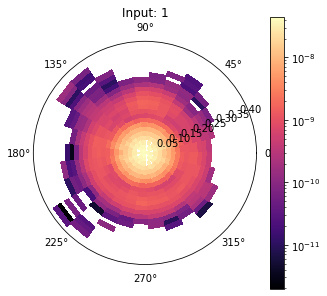

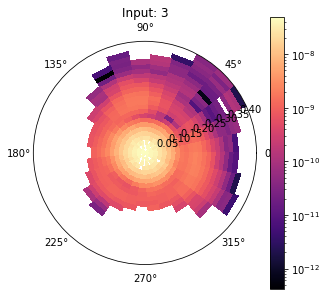

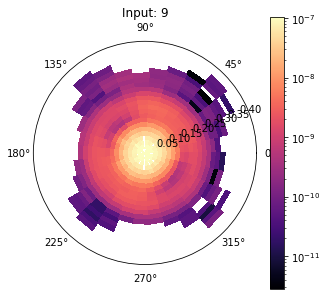

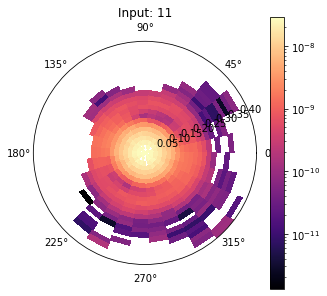

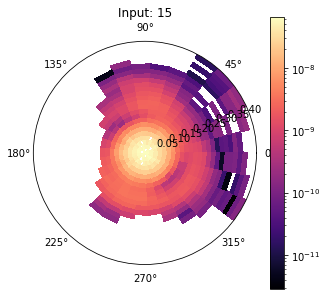

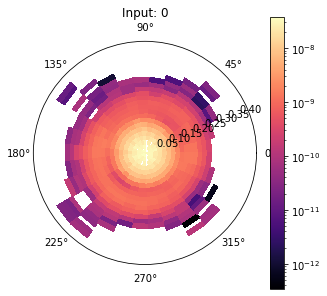

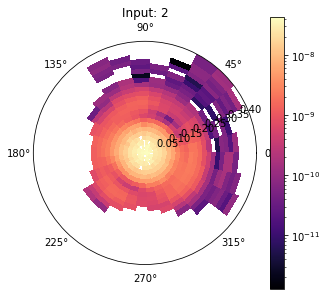

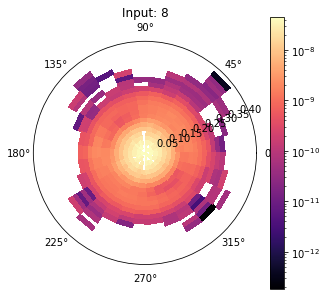

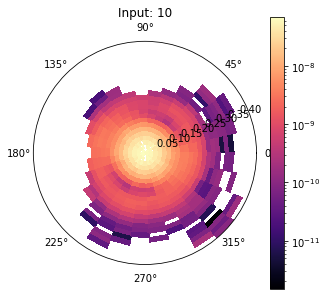

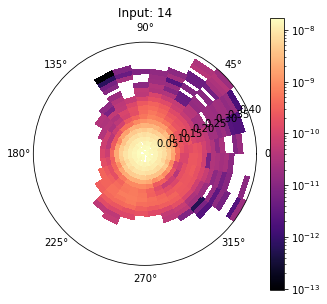

In [29]:

# Plot maps to check above binning

# Co-pol
for i,chind in enumerate(N_pols):
    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot(1, 1, 1, projection='polar')
    #plt.scatter(ptest.d0_centers_grid[:,:,chind],ptest.d1_centers_grid[:,:,chind],
    #           c=10*np.log10(np.abs(ptest.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-40,cmap=cm.magma)#,edgecolors='k')
    plt.pcolormesh(beam618.d0_edges_grid[:,:,chind],beam618.d1_edges_grid[:,:,chind],
                   beam618.V_LC_operation[:,:,0,chind],cmap=cm.magma,norm=LogNorm())
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

    

for i,chind in enumerate(E_pols):
    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot(1, 1, 1, projection='polar')
    #plt.scatter(ptest.d0_centers_grid[:,:,chind],ptest.d1_centers_grid[:,:,chind],
    #           c=10*np.log10(np.abs(ptest.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-40,cmap=cm.magma)#,edgecolors='k')
    plt.pcolormesh(beam620.d0_edges_grid[:,:,chind],beam620.d1_edges_grid[:,:,chind],
                   beam620.V_LC_operation[:,:,0,chind],cmap=cm.magma,norm=LogNorm())
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

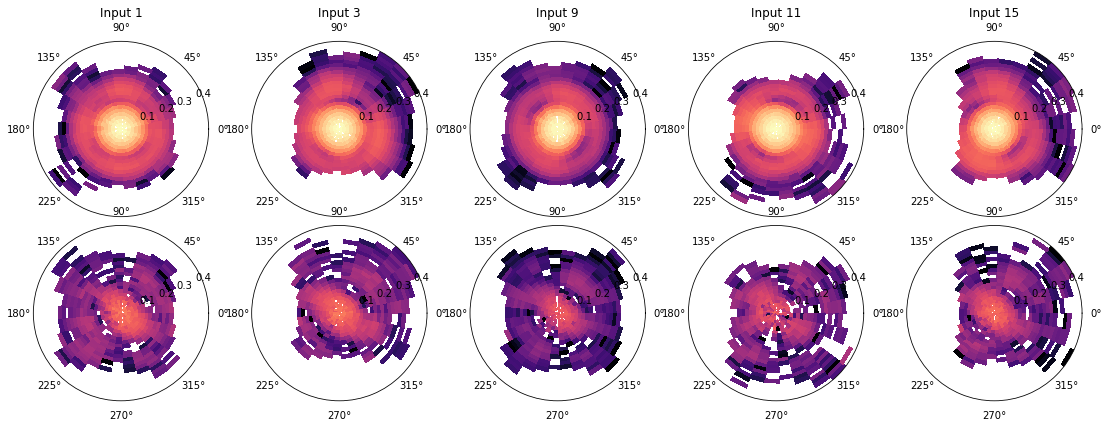

In [44]:
fig = plt.figure(figsize=(20,10))
for i,chind in enumerate(N_pols): 
    xco = beam618.d0_edges_grid[:,:,chind]
    yco = beam618.d1_edges_grid[:,:,chind]
    zco = beam618.V_LC_operation[:,:,0,chind] / gp_618[chind,find]

    ax = plt.subplot(3, 5, i + 1,projection='polar')
    ax.pcolormesh(xco,yco,zco,
        cmap=cm.magma,norm=LogNorm(vmin=vmi,vmax=vma)) 
    ax.set_title('Input '+str(chind))
    
    xcrs = beam620.d0_edges_grid[:,:,chind]
    ycrs = beam620.d1_edges_grid[:,:,chind]
    zcrs = beam620.V_LC_operation[:,:,0,chind] / gp_618[chind,find]
    
    ax = plt.subplot(3, 5, i + 6,projection='polar')
    # plot scatter plot and beam map
    ax.pcolormesh(xcrs,ycrs,zcrs,
        cmap=cm.magma,norm=LogNorm(vmin=vmi,vmax=vma))   
    #ax.set_ylim(0,0.3)

fig.subplots_adjust(hspace=0.05,wspace=-0.1)


plt.show()

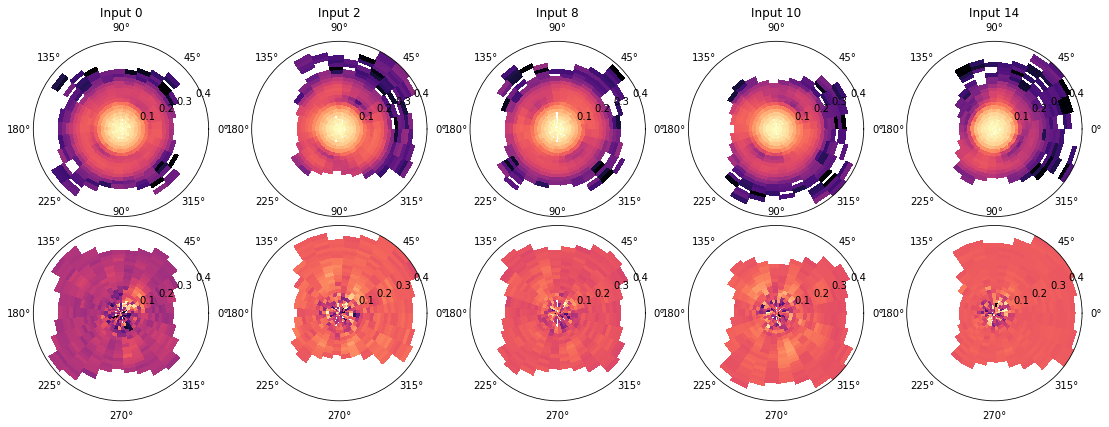

In [46]:
fig = plt.figure(figsize=(20,10))
for i,chind in enumerate(E_pols): 
    xco = beam620.d0_edges_grid[:,:,chind]
    yco = beam620.d1_edges_grid[:,:,chind]
    zco = beam620.V_LC_operation[:,:,0,chind] / gp_620[chind,find]

    ax = plt.subplot(3, 5, i + 1,projection='polar')
    ax.pcolormesh(xco,yco,zco,
        cmap=cm.magma,norm=LogNorm(vmin=vmi,vmax=vma)) 
    ax.set_title('Input '+str(chind))
    
    xcrs = beam618.d0_edges_grid[:,:,chind]
    ycrs = beam618.d1_edges_grid[:,:,chind]
    zcrs = beam618.V_LC_operation[:,:,0,chind] / gp_620[chind,find]
    
    ax = plt.subplot(3, 5, i + 6,projection='polar')
    # plot scatter plot and beam map
    ax.pcolormesh(xcrs,ycrs,zcrs,
        cmap=cm.magma)#,norm=LogNorm(vmin=vmi,vmax=vma))   
    #ax.set_ylim(0,0.3)

fig.subplots_adjust(hspace=0.05,wspace=-0.1)


plt.show()

In [22]:
##  The resolution above is not great if this is our one money plot to do slices
# Since I'm only really looking at two flights at two discrete heights
# Let's cartesian grid and turn into polar old school


In [47]:
pflights = ['618','620']

find=900


fly = '618'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)
concytest=glob.glob(pckldir+'*FLY'+fly+'*')
print(concytest)

beam618=Beammap_nonorm(concatlist=concytest,coordsys='cartesian',
                 operation='coadd',d0args=[-41.5,40,3],d1args=[-41.5,40,3],
                 Fargs=[find,find+1,1],f_index=find,vplot=False)

fly = '620'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)
concytest=glob.glob(pckldir+'*FLY'+fly+'*')
print(concytest)

beam620=Beammap_nonorm(concatlist=concytest,coordsys='cartesian',
                 operation='coadd',d0args=[-41.5,40,3],d1args=[-41.5,40,3],
                 Fargs=[find,find+1,1],f_index=find,vplot=False)


618 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
['/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl']
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl
start of big ass loop is: 2023-12-14 10:41:15.568917
618 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2023-12-14 10:41:18.681520          
end of concat loop is: 2023-12-14 10:41:18.682241


<ipython-input-42-92aad5768277>:187: RuntimeWarning: invalid value encountered in true_divide
  self.V_LC_operation = np.nansum(self.V_LC_sum,axis=4)/self.V_LC_operation_count


620 E [0, 2, 8, 10, 14] [1, 3, 9, 11, 15] 46
['/hirax/GBO_Analysis_Outputs/flight_pickles/FLY620_20211021T192212Z_ver_20231012T012215_concat.pkl']
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY620_20211021T192212Z_ver_20231012T012215_concat.pkl
start of big ass loop is: 2023-12-14 10:41:21.755280
620 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2023-12-14 10:41:24.791550          
end of concat loop is: 2023-12-14 10:41:24.792169


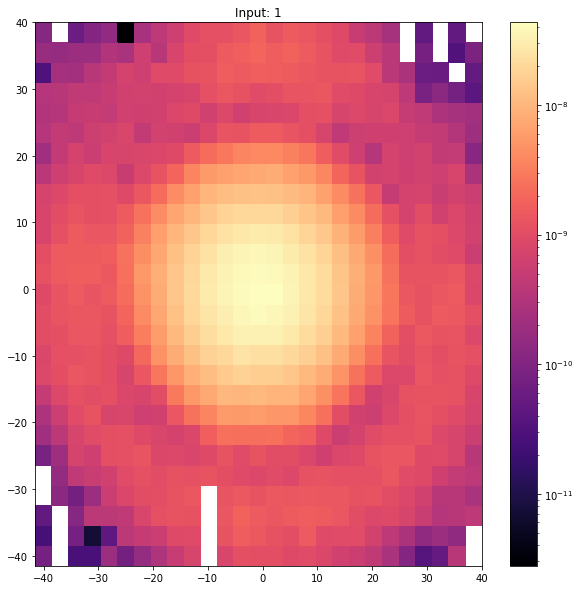

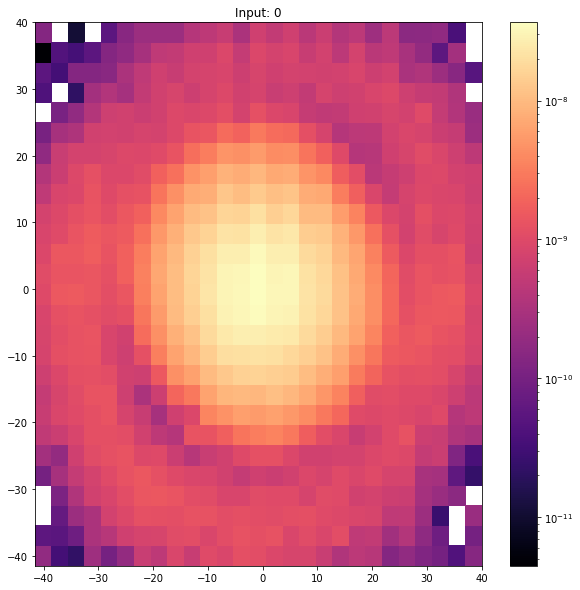

<ipython-input-24-2f1711a3c79d>:37: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(phi,theta,zco,


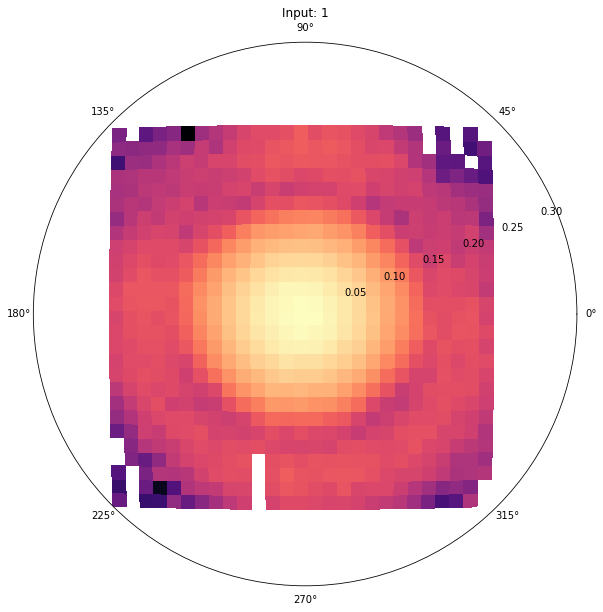

In [24]:
for i,chind in enumerate(N_pols[0:1]):
    fig = plt.figure(figsize=(10,10))
    #ax = plt.subplot(1, 1, 1, projection='polar')
    #plt.scatter(ptest.d0_centers_grid[:,:,chind],ptest.d1_centers_grid[:,:,chind],
    #           c=10*np.log10(np.abs(ptest.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-40,cmap=cm.magma)#,edgecolors='k')
    plt.pcolormesh(beam618.d0_edges_grid[:,:,chind],beam618.d1_edges_grid[:,:,chind],
                   beam618.V_LC_operation[:,:,0,chind],cmap=cm.magma,norm=LogNorm())
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

    

for i,chind in enumerate(E_pols[0:1]):
    fig = plt.figure(figsize=(10,10))
    #ax = plt.subplot(1, 1, 1, projection='polar')
    #plt.scatter(ptest.d0_centers_grid[:,:,chind],ptest.d1_centers_grid[:,:,chind],
    #           c=10*np.log10(np.abs(ptest.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-40,cmap=cm.magma)#,edgecolors='k')
    plt.pcolormesh(beam620.d0_edges_grid[:,:,chind],beam620.d1_edges_grid[:,:,chind],
                   beam620.V_LC_operation[:,:,0,chind],cmap=cm.magma,norm=LogNorm())
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()
    
z=177.
for i,chind in enumerate(N_pols[0:1]):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(1, 1, 1, projection='polar')
    xco = beam618.d0_edges_grid[:,:,chind]
    yco = beam618.d1_edges_grid[:,:,chind]
    zco = beam618.V_LC_operation[:,:,0,chind] / gp_618[chind,find]
    
    r = np.sqrt(xco**2 + yco**2 + z**2)
    theta = np.arccos(z/r)
    phi = np.sign(yco)*np.arccos(xco / np.sqrt(xco**2 + yco**2))

    ax.pcolormesh(phi,theta,zco,
                   cmap=cm.magma,vmin=1E-4,vmax=1,norm=LogNorm())#,edgecolors='k')
    ax.set_title('Input: '+str(chind))
plt.show()

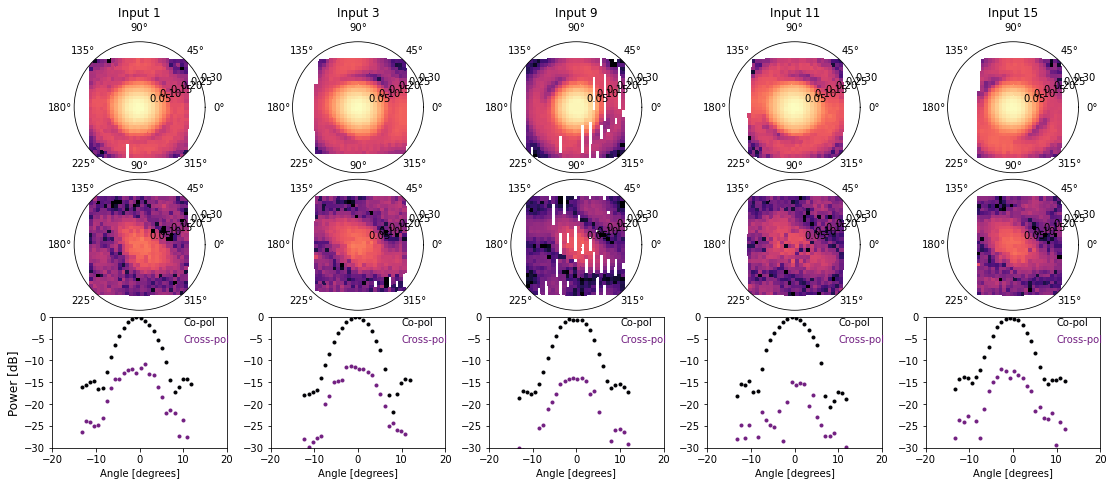

In [51]:
# The above seems like a good plan, lets do it
def convert_to_angle(d):
    h = 177.0 # meters
    aa = np.arctan(d/h)
    return np.degrees(aa)

colorz=pu.cm_to_discrete(cmm, 3)
find = 900
vmi = -40
vma = 0 
chind=1

# set up coordinates 
z = 177

fig = plt.figure(figsize=(20,10))

# plot things in the right places
for i,chind in enumerate(N_pols): 
    xco = beam618.d0_edges_grid[:,:,chind]
    yco = beam618.d1_edges_grid[:,:,chind]
    rco = np.sqrt(xco**2 + yco**2 + z**2)
    thetaco = np.arccos(z/rco)
    phico = np.sign(yco)*np.arccos(xco / np.sqrt(xco**2 + yco**2))
    zco = 10*np.log10(np.abs(beam618.V_LC_operation[:,:,0,chind] / gp_618[chind,find]))

    ax = plt.subplot(4, 5, i + 1,projection='polar')
    ax.pcolormesh(phico,thetaco,zco,
        cmap=cm.magma,vmin=vmi,vmax=vma) 
    ax.set_ylim(0,0.3)
    ax.set_title('Input '+str(chind))

    
    xcrs = beam620.d0_edges_grid[:,:,chind]
    ycrs = beam620.d1_edges_grid[:,:,chind]
    rcrs = np.sqrt(xcrs**2 + ycrs**2 + z**2)
    thetacrs = np.arccos(z/rcrs)
    phicrs = np.sign(ycrs)*np.arccos(xcrs / np.sqrt(xcrs**2 + ycrs**2))
    zcrs = 10*np.log10(np.abs(beam620.V_LC_operation[:,:,0,chind] / gp_618[chind,find]))
    
    ax = plt.subplot(4, 5, i + 6,projection='polar')
    # plot scatter plot and beam map
    ax.pcolormesh(phicrs,thetacrs,zcrs,
        cmap=cm.magma,vmin=vmi,vmax=vma)   
    ax.set_ylim(0,0.3)
    ax = plt.subplot(4, 5, i + 11,aspect=1)
    ## plot a cross-section - have to grab from cartesian and convert
    #col1,col2 = pu.get_polar_slice(xco,yco,0.0) # grabbed x slice
    #ax.plot(yco[col1,0:-1],10*np.log10(abs(zco[col1,:])),color=colorz[0],marker='.',linestyle='None',label='copol')
    #ax.plot(-1.*yco[col2,0:-1],10*np.log10(abs(zco[col2,:])),color=colorz[0],marker='.',linestyle='None',label='copol')
    #ax.plot(ycrs[col1,0:-1],10*np.log10(abs(zcrs[col1,:])),color=colorz[1],marker='.',linestyle='None',label='crosspol')
    #ax.plot(-1.*ycrs[col2,0:-1],10*np.log10(abs(zcrs[col2,:])),color=colorz[1],marker='.',linestyle='None',label='crosspol')
    ixd = get_slice_xy(xco,yco,0.0,ax='x')[0] # grabbed x slice
    ax.plot(convert_to_angle(yco[ixd,0:-1]),zco[ixd,:],color=colors[0],marker='.',linestyle='None',label='copol')
    ixd = get_slice_xy(xcrs,ycrs,0.0,ax='x')[0] # grabbed x slice
    ax.plot(convert_to_angle(ycrs[ixd,0:-1]),zcrs[ixd,:],color=colors[1],marker='.',linestyle='None',label='cross-pol')
    ax.set_ylim(-30,0)
    ax.set_xlim(-20,20)
    ax.text(10,-6,'Cross-pol',color=colorz[1])
    ax.text(10,-2,'Co-pol',color=colorz[0])
    ax.set_xlabel('Angle [degrees]')
    if i==0: 
        ax.set_ylabel('Power [dB]',fontsize=12)


# Do all the labelling
#ax1.text(-40,35,'Co-pol',color='white',fontsize=25)
#ax1.set_ylabel('Distance [m]',fontsize=10)
#ax1.set_title('Input '+str(chind))    
#axs[1,0].text(-40,35,'Cross-pol',color='white',fontsize=25)
fig.subplots_adjust(hspace=0.05,wspace=-0.1)


plt.show()

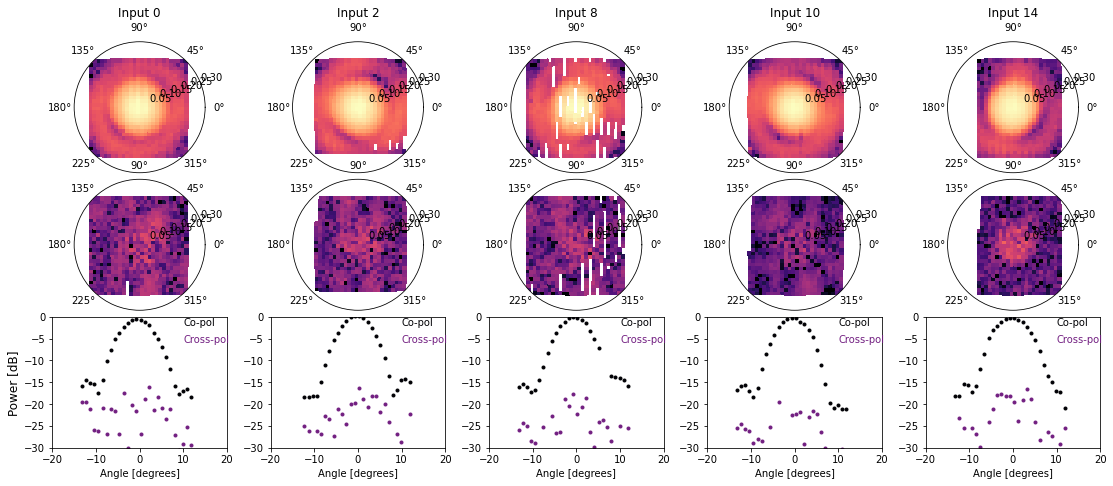

In [52]:
colorz=pu.cm_to_discrete(cmm, 3)
find = 900
vmi = -40
vma = 0
chind=1

# set up coordinates 
z = 177

fig = plt.figure(figsize=(20,10))

# plot things in the right places
for i,chind in enumerate(E_pols): 
    xco = beam620.d0_edges_grid[:,:,chind]
    yco = beam620.d1_edges_grid[:,:,chind]
    rco = np.sqrt(xco**2 + yco**2 + z**2)
    thetaco = np.arccos(z/rco)
    phico = np.sign(yco)*np.arccos(xco / np.sqrt(xco**2 + yco**2))
    zco = 10*np.log10(np.abs(beam620.V_LC_operation[:,:,0,chind] / gp_620[chind,find]))

    ax = plt.subplot(4, 5, i + 1,projection='polar')
    ax.pcolormesh(phico,thetaco,zco,
        cmap=cm.magma,vmin=vmi,vmax=vma) 
    ax.set_ylim(0,0.3)
    ax.set_title('Input '+str(chind))

    
    xcrs = beam618.d0_edges_grid[:,:,chind]
    ycrs = beam618.d1_edges_grid[:,:,chind]
    rcrs = np.sqrt(xcrs**2 + ycrs**2 + z**2)
    thetacrs = np.arccos(z/rcrs)
    phicrs = np.sign(ycrs)*np.arccos(xcrs / np.sqrt(xcrs**2 + ycrs**2))
    zcrs = 10*np.log10(np.abs(beam618.V_LC_operation[:,:,0,chind] / gp_620[chind,find]))
    
    ax = plt.subplot(4, 5, i + 6,projection='polar')
    # plot scatter plot and beam map
    ax.pcolormesh(phicrs,thetacrs,zcrs,
        cmap=cm.magma,vmin=vmi,vmax=vma)   
    ax.set_ylim(0,0.3)
    ax = plt.subplot(4, 5, i + 11,aspect=1)
    ## plot a cross-section - have to grab from cartesian and convert
    #col1,col2 = pu.get_polar_slice(xco,yco,0.0) # grabbed x slice
    #ax.plot(yco[col1,0:-1],10*np.log10(abs(zco[col1,:])),color=colorz[0],marker='.',linestyle='None',label='copol')
    #ax.plot(-1.*yco[col2,0:-1],10*np.log10(abs(zco[col2,:])),color=colorz[0],marker='.',linestyle='None',label='copol')
    #ax.plot(ycrs[col1,0:-1],10*np.log10(abs(zcrs[col1,:])),color=colorz[1],marker='.',linestyle='None',label='crosspol')
    #ax.plot(-1.*ycrs[col2,0:-1],10*np.log10(abs(zcrs[col2,:])),color=colorz[1],marker='.',linestyle='None',label='crosspol')
    ixd = get_slice_xy(xco,yco,0.0,ax='x')[0] # grabbed x slice
    ax.plot(convert_to_angle(yco[ixd,0:-1]),zco[ixd,:],color=colors[0],marker='.',linestyle='None',label='copol')
    ixd = get_slice_xy(xcrs,ycrs,0.0,ax='x')[0] # grabbed x slice
    ax.plot(convert_to_angle(ycrs[ixd,0:-1]),zcrs[ixd,:],color=colors[1],marker='.',linestyle='None',label='cross-pol')
    ax.set_ylim(-30,0)
    ax.set_xlim(-20,20)
    ax.text(10,-6,'Cross-pol',color=colorz[1])
    ax.text(10,-2,'Co-pol',color=colorz[0])
    ax.set_xlabel('Angle [degrees]')
    if i==0: 
        ax.set_ylabel('Power [dB]',fontsize=12)


# Do all the labelling
#ax1.text(-40,35,'Co-pol',color='white',fontsize=25)
#ax1.set_ylabel('Distance [m]',fontsize=10)
#ax1.set_title('Input '+str(chind))    
#axs[1,0].text(-40,35,'Cross-pol',color='white',fontsize=25)
fig.subplots_adjust(hspace=0.05,wspace=-0.1)


plt.show()

<ipython-input-98-2b079182958b>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(3, 2, 5,aspect=0.5)
<ipython-input-98-2b079182958b>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(3, 2, 5,aspect=0.5)
<ipython-input-98-2b079182958b>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new in

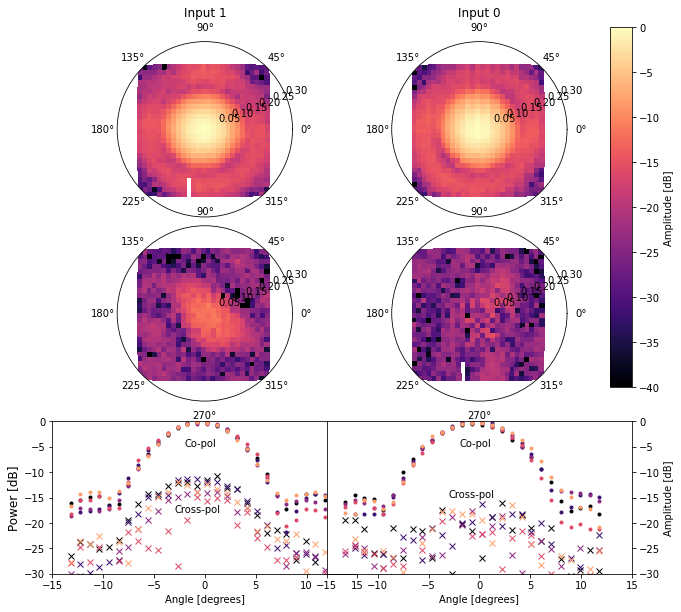

In [98]:
colorz=pu.cm_to_discrete(cmm, 5)
find = 900
vmi = -40
vma = 0 
chind=1

# set up coordinates 
z = 177

fig = plt.figure(figsize=(10,10))

# plot things in the right places
for i,chind in enumerate(N_pols): 
    xco = beam618.d0_edges_grid[:,:,chind]
    yco = beam618.d1_edges_grid[:,:,chind]
    rco = np.sqrt(xco**2 + yco**2 + z**2)
    thetaco = np.arccos(z/rco)
    phico = np.sign(yco)*np.arccos(xco / np.sqrt(xco**2 + yco**2))
    zco = 10*np.log10(np.abs(beam618.V_LC_operation[:,:,0,chind] / gp_618[chind,find]))   
    
    xcrs = beam620.d0_edges_grid[:,:,chind]
    ycrs = beam620.d1_edges_grid[:,:,chind]
    rcrs = np.sqrt(xcrs**2 + ycrs**2 + z**2)
    thetacrs = np.arccos(z/rcrs)
    phicrs = np.sign(ycrs)*np.arccos(xcrs / np.sqrt(xcrs**2 + ycrs**2))
    zcrs = 10*np.log10(np.abs(beam620.V_LC_operation[:,:,0,chind] / gp_618[chind,find]))

    if chind==N_pols[0]: # plot only the first channel
        ax = plt.subplot(3, 2, 1,projection='polar')
        ax.pcolormesh(phico,thetaco,zco,
            cmap=cm.magma,vmin=vmi,vmax=vma) 
        ax.set_ylim(0,0.3)
        ax.set_title('Input '+str(chind))

    
        ax = plt.subplot(3, 2, 3,projection='polar')
        # plot scatter plot and beam map
        ax.pcolormesh(phicrs,thetacrs,zcrs,
            cmap=cm.magma,vmin=vmi,vmax=vma)   
        ax.set_ylim(0,0.3)
        
    ax = plt.subplot(3, 2, 5,aspect=0.5)
    ixd = get_slice_xy(xco,yco,0.0,ax='x')[0] # grabbed x slice
    ax.plot(convert_to_angle(yco[ixd,0:-1]),zco[ixd,:],color=colorz[i],marker='.',linestyle='None',label='copol')
    ixd = get_slice_xy(xcrs,ycrs,0.0,ax='x')[0] # grabbed x slice
    ax.plot(convert_to_angle(ycrs[ixd,0:-1]),zcrs[ixd,:],color=colorz[i],marker='x',linestyle='None',label='cross-pol')
    ax.set_ylim(-30,0)
    ax.set_xlim(-15,15)
    
    if i==0: 
        ax.set_ylabel('Power [dB]',fontsize=12)
        ax.text(-3,-18,'Cross-pol',color=colorz[0],fontsize=10)
        ax.text(-2,-5,'Co-pol',color=colorz[0],fontsize=10)
        ax.set_xlabel('Angle [degrees]')

for i,chind in enumerate(E_pols): 
    xco = beam620.d0_edges_grid[:,:,chind]
    yco = beam620.d1_edges_grid[:,:,chind]
    rco = np.sqrt(xco**2 + yco**2 + z**2)
    thetaco = np.arccos(z/rco)
    phico = np.sign(yco)*np.arccos(xco / np.sqrt(xco**2 + yco**2))
    zco = 10*np.log10(np.abs(beam620.V_LC_operation[:,:,0,chind] / gp_620[chind,find]))
    
    xcrs = beam618.d0_edges_grid[:,:,chind]
    ycrs = beam618.d1_edges_grid[:,:,chind]
    rcrs = np.sqrt(xcrs**2 + ycrs**2 + z**2)
    thetacrs = np.arccos(z/rcrs)
    phicrs = np.sign(ycrs)*np.arccos(xcrs / np.sqrt(xcrs**2 + ycrs**2))
    zcrs = 10*np.log10(np.abs(beam618.V_LC_operation[:,:,0,chind] / gp_620[chind,find]))
    
    if chind==E_pols[0]: # plot only the first channel
        ax = plt.subplot(3, 2, 2,projection='polar')
        ax.pcolormesh(phico,thetaco,zco,
            cmap=cm.magma,vmin=vmi,vmax=vma) 
        ax.set_ylim(0,0.3)
        ax.set_title('Input '+str(chind))

    
        ax = plt.subplot(3, 2, 4,projection='polar')
        # plot scatter plot and beam map
        im = ax.pcolormesh(phicrs,thetacrs,zcrs,
            cmap=cm.magma,vmin=vmi,vmax=vma)   
        ax.set_ylim(0,0.3)
        
    ax = plt.subplot(3, 2, 6,aspect=0.5)

    ixd = get_slice_xy(xco,yco,0.0,ax='x')[0] # grabbed x slice
    ax.plot(convert_to_angle(yco[ixd,0:-1]),zco[ixd,:],color=colorz[i],marker='.',linestyle='None',label='copol')
    ixd = get_slice_xy(xcrs,ycrs,0.0,ax='x')[0] # grabbed x slice
    ax.plot(convert_to_angle(ycrs[ixd,0:-1]),zcrs[ixd,:],color=colorz[i],marker='x',linestyle='None',label='cross-pol')
    ax.set_ylim(-30,0)
    ax.set_xlim(-15,15)
    ax.yaxis.tick_right()
    if i==0:
        ax.set_xlabel('Angle [degrees]')
        ax.set_ylabel('Amplitude [dB]')
        ax.yaxis.set_label_position("right")
        ax.text(-3,-15,'Cross-pol',color=colorz[0],fontsize=10)
        ax.text(-2,-5,'Co-pol',color=colorz[0],fontsize=10)
      
fig.subplots_adjust(hspace=0.05,wspace=-0.1)

fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.9, 0.4, 0.03, 0.5])
fig.colorbar(im, cax=cbar_ax,aspect=50,label='Amplitude [dB]')      
fig.subplots_adjust(hspace=0.05,wspace=-0.1)

#fig.subplots_adjust(right=0.85)
#cbar_ax = fig.add_axes([0.9, 0.4, 0.03, 0.5])
#fig.colorbar(im, cax=cbar_ax,aspect=50,label='Amplitude [dB]')
###plt.tight_layout()
plt.show()